In [6]:
from sklearn.metrics import cohen_kappa_score
from pathlib import Path
import pandas as pd
from collections import defaultdict

In [7]:
scores_dir = Path("../scores")

#RSIF, ISF -  the bigger the score the bigger the anomaly. This is because score is multiplied by -1 before given to the AUC. 

# For the rest is the same as all are from the pyod library quote, The anomaly score of an input sample is computed based on the fitted detector. For consistency, outliers are assigned with higher anomaly scores.

#This is opposite to the common sklearn convention where the outlier/anomaly score lower than threshold is considered as abnormal.

In [9]:
def my_kappa(a1, a2):
    denominator = a1.shape[0]
    aggrements = (a1 == a2).sum()
    p_0 = aggrements / denominator

    p_e = 0
    for c in a1.unique():
        p_e += (a1 == c).sum() * (a2 == c).sum()
    p_e /= (denominator**2)

    return (p_0 - p_e) / (1 - p_e)

    

kappas = defaultdict(list)
my_kappas = defaultdict(list)
for score_path in scores_dir.iterdir():
    dataset = score_path.stem[:-2]
    scores = pd.read_csv(score_path)

    n_outliers = max(10, int(scores.shape[0] * 0.2))
    assignment = scores.rank(axis=0, ascending=False) <= n_outliers
    for i, a1 in enumerate(scores.columns):
        for a2 in scores.columns[i+1:]:
            my_kappas[(a1,a2)].append(my_kappa(assignment[a1], assignment[a2]))
            

In [90]:
# def get_norm_scores(raw_scores):
#     raw_min = raw_scores.min()
#     raw_max = raw_scores.max()
#     return (raw_scores - raw_min) / (raw_max - raw_min)

# icss = defaultdict(list)
# for score_path in scores_dir.iterdir():
#     dataset = score_path.stem
#     scores = pd.read_csv(score_path)
#     samples_id = np.char.add(scores.index.to_numpy().astype('U10'), f"_{dataset}").tolist()
#     for i, a1 in enumerate(scores.columns):
#         for a2 in scores.columns[i+1:]:
#             df = {
#                 "sample": [],
#                 "algorithm": [],
#                 "score": [],
#             }
#             df["sample"].extend(samples_id * 2)
#             df["algorithm"].extend([a1] * len(samples_id) + [a2] * len(samples_id))
#             df["score"].extend(get_norm_scores(scores[a1]).to_numpy().tolist())
#             df["score"].extend(get_norm_scores(scores[a2]).to_numpy().tolist())
#             df = pd.DataFrame(df)
#             icss[(a1,a2)].append(pg.intraclass_corr(data=df, targets='sample', raters='algorithm', ratings='score').iloc[2].ICC)

In [3]:
import pickle
with open("icss.pkl", "rb") as f:
    icss = pickle.load(f)

In [10]:
import numpy as np
df = {"alga": [], "algb": [], "iccs": []}
for k, v in my_kappas.items():
    #print(k, f" mean: {np.mean(v)}, std: {np.std(v)}")
    m = np.mean(v)
    df["alga"].append(k[0])
    df["algb"].append(k[1])
    df["alga"].append(k[1])
    df["algb"].append(k[0])
    df["iccs"].append(m)
    df["iccs"].append(m)


In [34]:
df

algb,ECOD,HBOS,IForest,ISF,LOF,RSIF
alga,,,,,,
ECOD,1.000000,0.744758,0.715985,0.459104,0.352882,0.567206
HBOS,0.744758,1.000000,0.679528,0.417764,0.339504,0.527199
IForest,0.715985,0.679528,1.000000,0.445831,0.378654,0.569092
ISF,0.459104,0.417764,0.445831,1.000000,0.247029,0.526602
LOF,0.352882,0.339504,0.378654,0.247029,1.000000,0.314341
RSIF,0.567206,0.527199,0.569092,0.526602,0.314341,1.000000


In [11]:
df = pd.DataFrame(df)
df = df.pivot_table(index="alga", columns="algb", values="iccs")
df[df.isna()] = 1

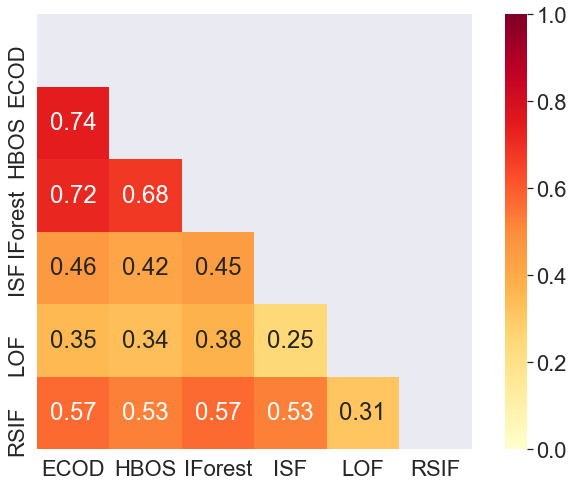

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mask
mask = np.triu(np.ones_like(df, dtype=bool))

# Create a custom divergin palette
cmap = sns.color_palette("YlOrRd", as_cmap=True)

plt.figure(figsize=(12, 8))
sns.set(font_scale=2)
ax = sns.heatmap(df, mask=mask, annot=True, fmt='.2f', square=True,cmap=cmap, vmin=0, vmax=1)

# plt.title("Cohen’s Kappa for the different algorithms", fontsize=16)

plt.xlabel("")
plt.ylabel("")
plt.savefig("icc.svg")
plt.show()